### Fitting Distributions with Scipy

If you have a dataset that was generated by a random process, you can fit the data to a statistical model using scipy.
In this notebook we will generate random data and fit to statistical models using scipy. 

In [1]:
# Use this magic command to plot in the notebook
%matplotlib inline
# Import base N-dimensional array package
import numpy as np
# Import 2D plotting library
import matplotlib.pyplot as plt
# Import several probability distributions from scipy.stats
from scipy.stats import (norm, lognorm, chi2, gamma, invgamma)

estimated mean: -0.00347240434781
estimated sigma: 0.10105543766


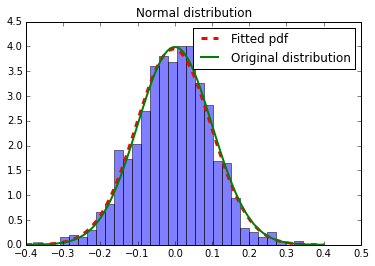

In [2]:
# Let's generate some random variables from a Gaussian distribution. Use numpy's random number generator. 
# We can specify the underlying distribution and its parameters. 
mu, sigma = 0, 0.1
data = norm.rvs(mu, sigma, size=1000)
x = np.linspace(-0.4, 0.4, 100)

# Now use matplotlib to plot the histogram
n, bins, patches = plt.hist(data, bins=30, normed=1, alpha=0.5)
plt.title('Normal distribution')

# Let's do a maximum likelihood fit on this data to estimate the parameters of the underlying distribution 
#(mu and sigma)
loc, scale = norm.fit(data)

print('estimated mean: %s' % loc)
print('estimated sigma: %s' % scale)

# Plot the original distribution and the fitted pdf
pdf = norm.pdf(x, loc=mu, scale=sigma)
pdf_norm = norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, pdf_norm, 'r--', label='Fitted pdf', linewidth=3)
plt.plot(x, pdf, 'g', linewidth=2, label='Original distribution')
plt.legend()



estimated mean: 0.00610028680965
estimated sigma: 0.5


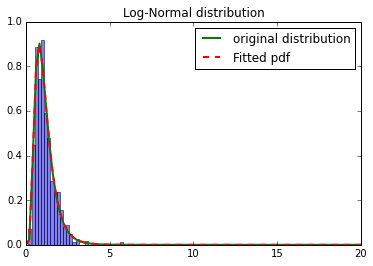

In [3]:
# Let's do the same thing with a log-Normal distribtion
mu, sigma = 0,  0.5
data = lognorm.rvs(s=sigma, loc=mu, size=1000)
x = np.linspace(0, 20, 100)

n, bins, patches = plt.hist(data, bins=30, normed=1, alpha=0.5)
plt.title('Log-Normal distribution')

sigma_f, loc, scale = lognorm.fit(data)

print('estimated mean: %s' % loc)
print('estimated sigma: %s' % sigma)

pdf = lognorm.pdf(x, sigma, loc=mu)
plt.plot(x, pdf, 'g', label='original distribution', linewidth=2)
pdf_lognorm = lognorm.pdf(x, sigma_f, loc=loc, scale=scale)
plt.plot(x, pdf_lognorm, 'r--', label='Fitted pdf', linewidth=2)
plt.legend()

##### Try some other distributions.
You can find all available distributions on [scipy's docs](https://docs.scipy.org/doc/scipy/reference/stats.html).  

##### Note:
All scipy.stats continuous distributions have loc and scale parameters, even if location is not used in that distributions. You might have to do some homework to figure out how these parameters map to the parameters of the distribution. If you are using a distribution where loc is not used, you should set ```floc=0``` when using the ```fit``` function to ensure that it doesn't treat it as a free parameter. 


### Kernal Density Estimate (KDE)
[KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) is a non-parameteric way to estimate a pdf of a distribution of random variables. Let's try it on a mixture of Gaussians.

Elapsed time: 0.288557052612


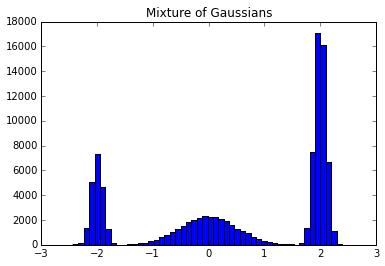

In [4]:
from scipy.stats.kde import gaussian_kde
import time
# Sample from a mixture of 3 Gaussians. First let's assign the weights (sum to 1), means and sigma for the components
# Timing this to compare the speed to using scipy to sample
t0 = time.time()
weights = np.array([0.2, 0.3, 0.5])
means = [-2, 0, 2]
sigmas = [0.1, 0.5, 0.1]

# Find the cdf of the weights and sample from that distribution
cdf = np.cumsum(weights)

samples = np.zeros(100000)
for i in range(samples.shape[0]):
    rand = np.random.random()
    # sample the component from the cdf
    m = cdf.searchsorted(rand)
    samples[i] = sigmas[m]*np.random.randn() + means[m]

t1 = time.time()
print('Elapsed time: %s' %(t1-t0))
n, bins, patches = plt.hist(samples, bins=50)
plt.title('Mixture of Gaussians')

It's also possible to generate samples of a Gaussian mixture using scipy.rvs instead of doing it in pure python. Since we timed both, we can see that using ```scipy.norm.rvs``` is 2 orders of magnitude faster! 

Elapsed time: 0.00612020492554


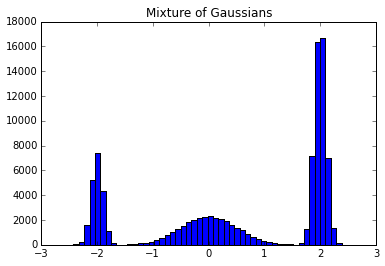

In [5]:
t0 = time.time()
samp_1 = norm.rvs(loc=-2.0,scale=0.1,size=20000)
samp_2 = norm.rvs(loc=0,scale=0.5,size=30000)
samp_3 = norm.rvs(loc=2, scale=0.1, size=50000)
samp = np.hstack([samp_1,samp_2, samp_3])
t1 = time.time()
print ('Elapsed time: %s' %(t1-t0))
n, bins, patches = plt.hist(samp, bins=50)
plt.title('Mixture of Gaussians')

Elapsed time: 0.00475406646729


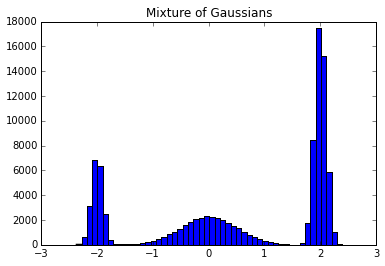

In [6]:
# And when compared to Numpy's random number generator, numpy comes out the winner! That's because scipy uses numpy's
# random number generator and there's some extra overhead. 
t0 = time.time()
samp_1 = np.random.normal(-2.0, 0.1,size=20000)
samp_2 = np.random.normal(0,scale=0.5,size=30000)
samp_3 = np.random.normal(2, scale=0.1, size=50000)
samp = np.hstack([samp_1,samp_2, samp_3])
t1 = time.time()
print ('Elapsed time: %s' %(t1-t0))
n, bins, patches = plt.hist(samp, bins=50)
plt.title('Mixture of Gaussians')

Since we're already comparing the speed of different random number generators, let's try the magic `%timeit`
function.


In [24]:
# Python's random number generator
import random

# Compare several generators
%timeit -n 1000 a = np.random.lognormal(1)
%timeit -n 1000 a = np.random.normal(1)
%timeit -n 1000 a = random.gauss(0, 0.1)
%timeit -n 1000 a = random.lognormvariate(0, 0.1)
%timeit -n 1000 a = norm.rvs(1)
%timeit -n 1000 a = lognorm.rvs(1)

1000 loops, best of 3: 767 ns per loop
1000 loops, best of 3: 533 ns per loop
1000 loops, best of 3: 1.91 µs per loop
1000 loops, best of 3: 3.31 µs per loop
1000 loops, best of 3: 26.1 µs per loop
1000 loops, best of 3: 32.9 µs per loop


If you need to consider speed, you should use `numpy.random`. 

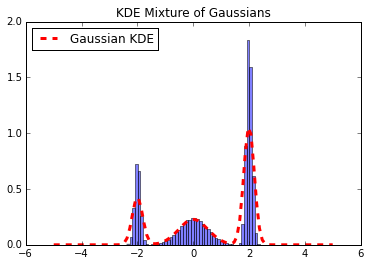

In [7]:
# obtaining the pdf 
kernal = gaussian_kde(samp)

# plotting the result
x = np.linspace(-5,5,100)
plt.plot(x, kernal(x), 'r--', linewidth=3, label='Gaussian KDE') # distribution function
n, bins, patches = plt.hist(samp, normed=1, bins=50, alpha=0.5) # histogram
plt.legend(loc='upper left')
plt.title('KDE Mixture of Gaussians')

Let's Try a 2D Gaussian. 

First generate 2D data.

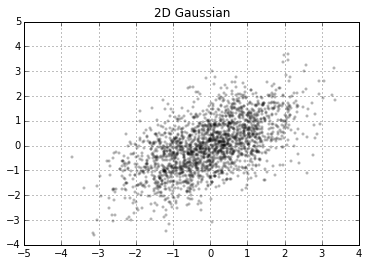

In [8]:
samp_1 = norm.rvs(scale=1.0,size=2000)
samp_2 = norm.rvs(scale=0.5,size=2000)
m1 = samp_1 - samp_2
m2 = samp_1 + samp_2
plt.scatter(m1, m2, alpha=0.2, marker='.', color='black')
plt.title('2D Gaussian')
plt.grid(True)

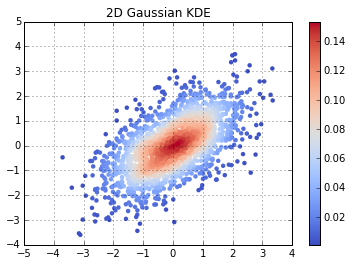

In [9]:
# KDE on 2D data

values = np.vstack([m1, m2])
kernal = gaussian_kde(values)
pdf = kernal(values)
plt.scatter(m1, m2, marker='o', c=pdf, edgecolors='', cmap='coolwarm')
plt.grid(True)
plt.colorbar()
plt.title('2D Gaussian KDE')


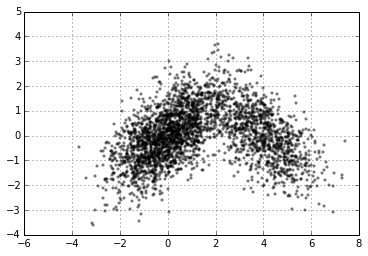

In [10]:
# Let's try a KDE on more than one component
# First generate the data
samp_3 = norm.rvs(loc=2, scale=1.0,size=1000)
samp_4 = norm.rvs(loc=2, scale=0.5,size=1000)
m3 = samp_3 + samp_4
m4 = samp_4 - samp_3
m5 = np.hstack([m1, m3])
m6 = np.hstack([m2, m4])
plt.scatter(m5, m6, marker='.', color='black', alpha=0.4)
plt.grid(True)

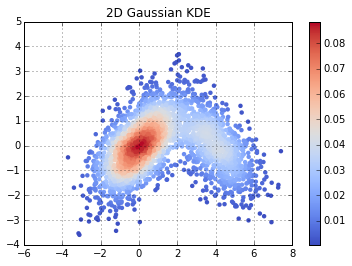

In [11]:
values = np.vstack([m5, m6])
kernel = gaussian_kde(values)
plt.scatter(m5, m6, marker='o', c=kernel(values), edgecolors='', cmap='coolwarm')
plt.grid(True)
plt.colorbar()
plt.title('2D Gaussian KDE')

In the above case, we only evaluated the KDE on the random variables. Let's evaluate it on a grid.


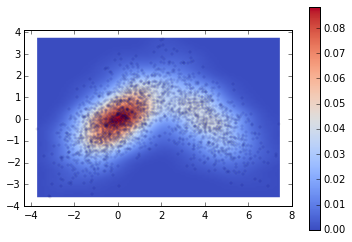

In [12]:
# Create grid to evaluate KDE on (serves same purpose as x in the 1D case)
xmin = m5.min()
xmax = m5.max()
ymin = m6.min()
ymax = m6.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions), X.shape)

# Plot the KDE
plt.imshow(np.rot90(Z), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
# Plot the data 
plt.scatter(m5, m6, marker='.', alpha=0.08)

matplotlib also has a 2D histogram. Since the KDE is a smoothing function, the histrogram will be less smooth.

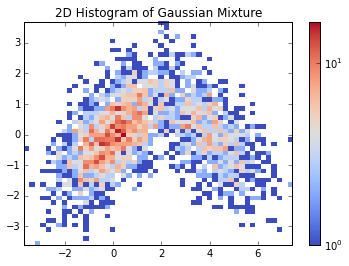

In [13]:
from matplotlib.colors import LogNorm
plt.hist2d(m5, m6, bins=50, cmap='coolwarm', norm=LogNorm())
plt.colorbar()
plt.title('2D Histogram of Gaussian Mixture')

Add Histograms to the scatter plot. You can find an example [here](http://matplotlib.org/examples/pylab_examples/scatter_hist.html)

How about a 3D Gaussians?

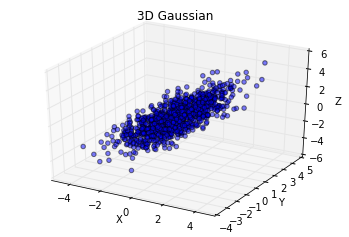

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

samp_1 = norm.rvs(scale=1.0,size=1000)
samp_2 = norm.rvs(scale=0.5,size=1000)
samp_3 = norm.rvs(scale=0.2, size=1000)
m1 = samp_1 - samp_2 + samp_3
m2 = samp_1 + samp_2 - samp_3
m3 = samp_1 + samp_2 + samp_3

ax.scatter(xs=m1, ys=m2, zs=m3, marker='o', edgecolors='', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Gaussian')

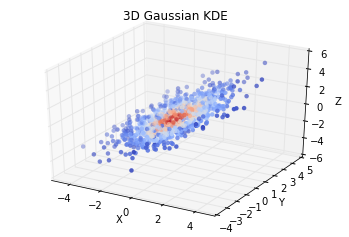

In [15]:
# Evaluate KDE
values = np.vstack([m1, m2, m3])
kde = gaussian_kde(values)
density = kde(values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=m1, ys=m2, zs=m3, marker='o', c=density, cmap='coolwarm', edgecolors='')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Gaussian KDE')